# IMPORT STATMENTS FOR ALL MODLES

In [6]:
!TMPDIR=/home/mgill/ pip install --cache-dir=/home/mgill/ --build /home/mgill/ pandas numpy sklearn xgboost matplotlib tensorflow==2.1.0 keras==2.2.4 fastai python-dateutil scikit-optimize scikit-learn==0.21 seaborn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [8]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from math import sqrt
from statistics import mean
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.impute import SimpleImputer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
import pickle
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

2.1.0
2.2.4


In [9]:
def new_prep_data(tt_file, ho_file):
    imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
    my_list = []
    x = 0 
    for chunk in pd.read_csv(tt_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            tt_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(tt_pheno.shape)
            tt_pheno = np.reshape(tt_pheno,(len(tt_pheno),1))
            print(tt_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    tt_vcf = pd.concat(my_list, axis = 1)
    my_list = []
    x=0
    for chunk in pd.read_csv(ho_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            ho_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(ho_pheno.shape)
            ho_pheno = np.reshape(ho_pheno,(len(ho_pheno),1))
            print(ho_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    ho_vcf = pd.concat(my_list, axis = 1)
    print(tt_vcf.shape)
    print(ho_vcf.shape)
    return tt_vcf, ho_vcf, tt_pheno, ho_pheno

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("Pro_Merged_filtered.csv_train_testQTL_SNPS.csv", "Pro_Merged_filtered.csv_holdoutQTL_SNPS.csv")

10000
20000
(753,)
(753, 1)
30000
10000
20000
(189,)
(189, 1)
30000
(753, 23023)
(189, 23023)


In [5]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe = ohe.fit(tt_vcf)
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(753, 23023)
(753, 67713)
(189, 23023)
(189, 67713)


In [6]:
pickle.dump(ohe, open("Pro_QTL_ohe.dat", "wb"))

In [7]:
#if need or have new holdout data etc.
ohe = pickle.load(open("Pro_QTL_ohe.dat", "rb"))

In [4]:
def find_snp_from_header(ohe,snp_num):
    count = 0
    snp = "Not found"
    found = False
    i = 0
    while i < len(ohe.categories_) and (found == False):
        j = 0
        while j < len(ohe.categories_[i]):
            if(count == snp_num):
                snp = ohe.categories_[i][j]
                found = True
                break
            count = count + 1
            j = j + 1
        i = i + 1
    return snp

In [9]:
## TESTING IF IT WORKS
my_snp = find_snp_from_header(ohe, 108005)
print(my_snp)

Not found


# XGBoost ML Model

In [10]:
print(tt_vcf.shape)
print(tt_pheno.shape)
seed = randint(0,5000)
X_train, X_test, y_train, y_test = train_test_split(tt_vcf, tt_pheno, test_size=0.2, random_state=seed)
print(X_test.shape)
print("seed is " + str(seed))

(753, 67713)
(753, 1)
(151, 67713)
seed is 3812


In [11]:
space ={'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'max_depth': Integer(0, 50),
        'max_delta_step': Integer(0, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(0, 5),
        'n_estimators': Integer(50, 200),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}


In [12]:
def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = xgb_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

In [13]:
xgbreg = xgb.XGBRegressor()
xgb_bayes_search = BayesSearchCV(xgbreg, space, n_iter=32, # specify how many iterations
                                    scoring=None, n_jobs=1, cv=5, verbose=3, random_state=42, n_points=12,
                                 refit=True)
xgb_bayes_search.fit(X_train, y_train.ravel(), callback = on_step)
print(xgb_bayes_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.104, total=  14.4s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.4s remaining:    0.0s


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.284, total=  13.6s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.0s remaining:    0.0s


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.186, total=  13.4s
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.0593607063591

[CV]  colsample_bylevel=0.25617325301227906, colsample_bytree=0.7083937150495909, gamma=2.41812432168581e-07, learning_rate=0.13965555720269418, max_delta_step=10, max_depth=27, min_child_weight=1, n_estimators=76, reg_alpha=3.178148842971562e-08, reg_lambda=0.005381781269387993, scale_pos_weight=0.23835043249575294, subsample=0.9559763235078597, score=0.163, total=   8.6s
[CV] colsample_bylevel=0.7711308526006485, colsample_bytree=0.07988300914246868, gamma=1.3877597085692663e-08, learning_rate=0.15021004353467043, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=77, reg_alpha=0.006097622112520179, reg_lambda=1.9368851099909265e-09, scale_pos_weight=6.97020795804701e-06, subsample=0.46717487628832827 
[CV]  colsample_bylevel=0.7711308526006485, colsample_bytree=0.07988300914246868, gamma=1.3877597085692663e-08, learning_rate=0.15021004353467043, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=77, reg_alpha=0.006097622112520179, reg_lambda=1.9368851099909

[CV]  colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, scale_pos_weight=0.4420166988445819, subsample=0.037978567417966985, score=-52.087, total=   4.6s
[CV] colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, scale_pos_weight=0.4420166988445819, subsample=0.037978567417966985 
[CV]  colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, 

[CV]  colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868, score=0.122, total=  11.1s
[CV] colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868 
[CV]  colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.74397517665941

[CV]  colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, scale_pos_weight=5.68219069233494e-06, subsample=0.3682037565911086, score=-131.982, total=   4.5s
[CV] colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, scale_pos_weight=5.68219069233494e-06, subsample=0.3682037565911086 
[CV]  colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386,

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.9min finished


best score: 0.2614242841840209
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=0.763337652594658, colsample_bytree=0.6294637343462227, gamma=5.0982699811837615e-06, learning_rate=0.1482917460486716, max_delta_step=13, max_depth=2, min_child_weight=2, n_estimators=184, reg_alpha=0.2903630215416955, reg_lambda=1.7076871391684879e-09, scale_pos_weight=0.004947123172781688, subsample=0.10351123349878955 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.763337652594658, colsample_bytree=0.6294637343462227, gamma=5.0982699811837615e-06, learning_rate=0.1482917460486716, max_delta_step=13, max_depth=2, min_child_weight=2, n_estimators=184, reg_alpha=0.2903630215416955, reg_lambda=1.7076871391684879e-09, scale_pos_weight=0.004947123172781688, subsample=0.10351123349878955, score=-0.353, total=  10.4s
[CV] colsample_bylevel=0.763337652594658, colsample_bytree=0.6294637343462227, gamma=5.0982699811837615e-06, learning_rate=0.1482917460486716, max_delta_step=13, max_depth=2, min_child_weight=2, n_estimators=184, reg_alpha=0.2903630215416955, reg_lambda=1.7076871391684879e-09, scale_pos_weight=0.004947123172781688, subsample=0.10351123349878955 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV]  colsample_bylevel=0.763337652594658, colsample_bytree=0.6294637343462227, gamma=5.0982699811837615e-06, learning_rate=0.1482917460486716, max_delta_step=13, max_depth=2, min_child_weight=2, n_estimators=184, reg_alpha=0.2903630215416955, reg_lambda=1.7076871391684879e-09, scale_pos_weight=0.004947123172781688, subsample=0.10351123349878955, score=-0.121, total=  12.3s
[CV] colsample_bylevel=0.763337652594658, colsample_bytree=0.6294637343462227, gamma=5.0982699811837615e-06, learning_rate=0.1482917460486716, max_delta_step=13, max_depth=2, min_child_weight=2, n_estimators=184, reg_alpha=0.2903630215416955, reg_lambda=1.7076871391684879e-09, scale_pos_weight=0.004947123172781688, subsample=0.10351123349878955 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.6s remaining:    0.0s


[CV]  colsample_bylevel=0.763337652594658, colsample_bytree=0.6294637343462227, gamma=5.0982699811837615e-06, learning_rate=0.1482917460486716, max_delta_step=13, max_depth=2, min_child_weight=2, n_estimators=184, reg_alpha=0.2903630215416955, reg_lambda=1.7076871391684879e-09, scale_pos_weight=0.004947123172781688, subsample=0.10351123349878955, score=-0.363, total=  10.9s
[CV] colsample_bylevel=0.763337652594658, colsample_bytree=0.6294637343462227, gamma=5.0982699811837615e-06, learning_rate=0.1482917460486716, max_delta_step=13, max_depth=2, min_child_weight=2, n_estimators=184, reg_alpha=0.2903630215416955, reg_lambda=1.7076871391684879e-09, scale_pos_weight=0.004947123172781688, subsample=0.10351123349878955 
[CV]  colsample_bylevel=0.763337652594658, colsample_bytree=0.6294637343462227, gamma=5.0982699811837615e-06, learning_rate=0.1482917460486716, max_delta_step=13, max_depth=2, min_child_weight=2, n_estimators=184, reg_alpha=0.2903630215416955, reg_lambda=1.7076871391684879e-

[CV]  colsample_bylevel=0.3567012299496713, colsample_bytree=0.17153604698108554, gamma=0.019176590636599853, learning_rate=0.06128323623422292, max_delta_step=12, max_depth=9, min_child_weight=2, n_estimators=200, reg_alpha=2.6670162674837823e-06, reg_lambda=0.005983076832644179, scale_pos_weight=1.0798530594584035, subsample=0.20461993102422585, score=0.080, total=  10.0s
[CV] colsample_bylevel=0.195686556763755, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=14, max_depth=16, min_child_weight=1, n_estimators=67, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=499.99999999999994, subsample=1.0 
[CV]  colsample_bylevel=0.195686556763755, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.01, max_delta_step=14, max_depth=16, min_child_weight=1, n_estimators=67, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=499.99999999999994, subsample=1.0, score=-161.302, total=   4.4s
[CV] colsample_bylevel=0.195686556763755, colsample_bytree=1.0, gamma=1e-09, learn

[CV]  colsample_bylevel=0.5896341286996907, colsample_bytree=0.13229131086906146, gamma=1e-09, learning_rate=1.0, max_delta_step=20, max_depth=16, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=0.04722166367643623, scale_pos_weight=1e-06, subsample=1.0, score=-0.334, total=   3.3s
[CV] colsample_bylevel=0.5896341286996907, colsample_bytree=0.13229131086906146, gamma=1e-09, learning_rate=1.0, max_delta_step=20, max_depth=16, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=0.04722166367643623, scale_pos_weight=1e-06, subsample=1.0 
[CV]  colsample_bylevel=0.5896341286996907, colsample_bytree=0.13229131086906146, gamma=1e-09, learning_rate=1.0, max_delta_step=20, max_depth=16, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=0.04722166367643623, scale_pos_weight=1e-06, subsample=1.0, score=-0.498, total=   3.5s
[CV] colsample_bylevel=0.01, colsample_bytree=0.01, gamma=1e-09, learning_rate=1.0, max_delta_step=0, max_depth=0, min_child_weight=5, 

[CV]  colsample_bylevel=1.0, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=0, max_depth=0, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=1.0, score=-0.000, total=   2.7s
[CV] colsample_bylevel=1.0, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=0, max_depth=0, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=1.0 
[CV]  colsample_bylevel=1.0, colsample_bytree=0.01, gamma=0.49999999999999994, learning_rate=1.0, max_delta_step=0, max_depth=0, min_child_weight=0, n_estimators=50, reg_alpha=1.0, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=1.0, score=-0.034, total=   2.6s
[CV] colsample_bylevel=0.7673861161033368, colsample_bytree=0.8556270467719808, gamma=1e-09, learning_rate=0.23899304833277973, max_delta_step=5, max_depth=0, min_child_weight=3, n_estimators=173, reg_alpha=0.005279918498652339,

[CV]  colsample_bylevel=0.4998835942504129, colsample_bytree=0.6106031241654198, gamma=0.11706770208251183, learning_rate=0.8826701507442738, max_delta_step=0, max_depth=7, min_child_weight=3, n_estimators=184, reg_alpha=6.974380790356801e-08, reg_lambda=0.053692265193701225, scale_pos_weight=1.007558782351229e-05, subsample=0.7939600637226615, score=-0.295, total=  14.5s
[CV] colsample_bylevel=0.4998835942504129, colsample_bytree=0.6106031241654198, gamma=0.11706770208251183, learning_rate=0.8826701507442738, max_delta_step=0, max_depth=7, min_child_weight=3, n_estimators=184, reg_alpha=6.974380790356801e-08, reg_lambda=0.053692265193701225, scale_pos_weight=1.007558782351229e-05, subsample=0.7939600637226615 
[CV]  colsample_bylevel=0.4998835942504129, colsample_bytree=0.6106031241654198, gamma=0.11706770208251183, learning_rate=0.8826701507442738, max_delta_step=0, max_depth=7, min_child_weight=3, n_estimators=184, reg_alpha=6.974380790356801e-08, reg_lambda=0.053692265193701225, sc

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.8min finished


best score: 0.2614242841840209
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] colsample_bylevel=0.2341579169792944, colsample_bytree=0.7199493950346322, gamma=1.5331169100001126e-07, learning_rate=0.15047178506966605, max_delta_step=8, max_depth=29, min_child_weight=1, n_estimators=79, reg_alpha=1.56813372339453e-08, reg_lambda=0.00393790322128457, scale_pos_weight=0.9160045363230492, subsample=0.9559076629436477 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.2341579169792944, colsample_bytree=0.7199493950346322, gamma=1.5331169100001126e-07, learning_rate=0.15047178506966605, max_delta_step=8, max_depth=29, min_child_weight=1, n_estimators=79, reg_alpha=1.56813372339453e-08, reg_lambda=0.00393790322128457, scale_pos_weight=0.9160045363230492, subsample=0.9559076629436477, score=0.218, total=   8.9s
[CV] colsample_bylevel=0.2341579169792944, colsample_bytree=0.7199493950346322, gamma=1.5331169100001126e-07, learning_rate=0.15047178506966605, max_delta_step=8, max_depth=29, min_child_weight=1, n_estimators=79, reg_alpha=1.56813372339453e-08, reg_lambda=0.00393790322128457, scale_pos_weight=0.9160045363230492, subsample=0.9559076629436477 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV]  colsample_bylevel=0.2341579169792944, colsample_bytree=0.7199493950346322, gamma=1.5331169100001126e-07, learning_rate=0.15047178506966605, max_delta_step=8, max_depth=29, min_child_weight=1, n_estimators=79, reg_alpha=1.56813372339453e-08, reg_lambda=0.00393790322128457, scale_pos_weight=0.9160045363230492, subsample=0.9559076629436477, score=0.358, total=   8.5s
[CV] colsample_bylevel=0.2341579169792944, colsample_bytree=0.7199493950346322, gamma=1.5331169100001126e-07, learning_rate=0.15047178506966605, max_delta_step=8, max_depth=29, min_child_weight=1, n_estimators=79, reg_alpha=1.56813372339453e-08, reg_lambda=0.00393790322128457, scale_pos_weight=0.9160045363230492, subsample=0.9559076629436477 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s


[CV]  colsample_bylevel=0.2341579169792944, colsample_bytree=0.7199493950346322, gamma=1.5331169100001126e-07, learning_rate=0.15047178506966605, max_delta_step=8, max_depth=29, min_child_weight=1, n_estimators=79, reg_alpha=1.56813372339453e-08, reg_lambda=0.00393790322128457, scale_pos_weight=0.9160045363230492, subsample=0.9559076629436477, score=0.232, total=   8.7s
[CV] colsample_bylevel=0.2341579169792944, colsample_bytree=0.7199493950346322, gamma=1.5331169100001126e-07, learning_rate=0.15047178506966605, max_delta_step=8, max_depth=29, min_child_weight=1, n_estimators=79, reg_alpha=1.56813372339453e-08, reg_lambda=0.00393790322128457, scale_pos_weight=0.9160045363230492, subsample=0.9559076629436477 
[CV]  colsample_bylevel=0.2341579169792944, colsample_bytree=0.7199493950346322, gamma=1.5331169100001126e-07, learning_rate=0.15047178506966605, max_delta_step=8, max_depth=29, min_child_weight=1, n_estimators=79, reg_alpha=1.56813372339453e-08, reg_lambda=0.00393790322128457, sca

[CV]  colsample_bylevel=0.01, colsample_bytree=1.0, gamma=0.0007564105076474361, learning_rate=0.04338376760747042, max_delta_step=20, max_depth=30, min_child_weight=4, n_estimators=184, reg_alpha=0.0001077435390841637, reg_lambda=0.0010172300167651815, scale_pos_weight=0.8538392431962444, subsample=0.4036586363679742, score=0.250, total=  11.6s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.4813587770731583, max_delta_step=20, max_depth=0, min_child_weight=0, n_estimators=200, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=1.0 
[CV]  colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.4813587770731583, max_delta_step=20, max_depth=0, min_child_weight=0, n_estimators=200, reg_alpha=1e-09, reg_lambda=1000.0, scale_pos_weight=1e-06, subsample=1.0, score=-0.005, total=   7.5s
[CV] colsample_bylevel=1.0, colsample_bytree=1.0, gamma=1e-09, learning_rate=0.4813587770731583, max_delta_step=20, max_depth=0, min_child_

[CV]  colsample_bylevel=0.09593813230827578, colsample_bytree=0.20782373111954194, gamma=8.795033767646738e-07, learning_rate=0.05612451698131397, max_delta_step=17, max_depth=23, min_child_weight=2, n_estimators=188, reg_alpha=4.055399933344749e-05, reg_lambda=1.0603865229371803e-07, scale_pos_weight=0.8003808602300716, subsample=0.7035628536631454, score=0.289, total=  11.2s
[CV] colsample_bylevel=0.09593813230827578, colsample_bytree=0.20782373111954194, gamma=8.795033767646738e-07, learning_rate=0.05612451698131397, max_delta_step=17, max_depth=23, min_child_weight=2, n_estimators=188, reg_alpha=4.055399933344749e-05, reg_lambda=1.0603865229371803e-07, scale_pos_weight=0.8003808602300716, subsample=0.7035628536631454 
[CV]  colsample_bylevel=0.09593813230827578, colsample_bytree=0.20782373111954194, gamma=8.795033767646738e-07, learning_rate=0.05612451698131397, max_delta_step=17, max_depth=23, min_child_weight=2, n_estimators=188, reg_alpha=4.055399933344749e-05, reg_lambda=1.0603

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  6.6min finished


best score: 0.27864595813054166
OrderedDict([('colsample_bylevel', 0.09593813230827578), ('colsample_bytree', 0.20782373111954194), ('gamma', 8.795033767646738e-07), ('learning_rate', 0.05612451698131397), ('max_delta_step', 17), ('max_depth', 23), ('min_child_weight', 2), ('n_estimators', 188), ('reg_alpha', 4.055399933344749e-05), ('reg_lambda', 1.0603865229371803e-07), ('scale_pos_weight', 0.8003808602300716), ('subsample', 0.7035628536631454)])


In [ ]:
#check to make sure all the data has remained the same
np.isnan(X_train).any()
np.isnan(y_train).any()

np.isinf(X_train).any()
np.isinf(y_train).any()

In [14]:
xgb_bayes_search.best_params_

OrderedDict([('colsample_bylevel', 0.09593813230827578),
             ('colsample_bytree', 0.20782373111954194),
             ('gamma', 8.795033767646738e-07),
             ('learning_rate', 0.05612451698131397),
             ('max_delta_step', 17),
             ('max_depth', 23),
             ('min_child_weight', 2),
             ('n_estimators', 188),
             ('reg_alpha', 4.055399933344749e-05),
             ('reg_lambda', 1.0603865229371803e-07),
             ('scale_pos_weight', 0.8003808602300716),
             ('subsample', 0.7035628536631454)])

In [15]:
##START HERE

#xgbreg = xgb_bayes_search.best_estimator_ #xgb.XGBRegressor(#n_estimators=100, nthread=-1) 
best_params = xgb_bayes_search.best_params_

#best_params = OrderedDict([('colsample_bylevel', 0.88542798001491),
 #            ('colsample_bytree', 0.15107725561517718),
  ##          ('learning_rate', 0.11437510345794359),
    #         ('max_delta_step', 0),
     #        ('max_depth', 6),
      #       ('min_child_weight', 5),
       #      ('n_estimators', 200),
        #     ('reg_alpha', 1.2952579279714691e-08),
         #    ('reg_lambda', 0.45707493844512304),
          #   ('scale_pos_weight', 10.561837873121673),
           #  ('subsample', 0.9105119208713889)])
xgbreg = xgb.XGBRegressor(**best_params)

In [16]:
print(xgbreg)

XGBRegressor(base_score=None, booster=None,
             colsample_bylevel=0.09593813230827578, colsample_bynode=None,
             colsample_bytree=0.20782373111954194, gamma=8.795033767646738e-07,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.05612451698131397, max_delta_step=17, max_depth=23,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=188, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None,
             reg_alpha=4.055399933344749e-05, reg_lambda=1.0603865229371803e-07,
             scale_pos_weight=0.8003808602300716, subsample=0.7035628536631454,
             tree_method=None, validate_parameters=None, verbosity=None)


In [17]:
def eval_k_fold(m, x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = m
    i = 1
    for train,test in cv.split(x,y):
        #print(y[test])
        m.fit(x[train],y[train].ravel())
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [18]:
best_model = eval_k_fold(xgbreg, tt_vcf, tt_pheno, 10)

fitting done. Processing fold accuracy + checking best model
R^2 Value is: -0.3003329362144571
RMSE for dataset is:2.5522501573079617& mean of this fold is 45.280262
this is 5.636562256816253% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: -1.1118147470303241
RMSE for dataset is:2.9285168559608756& mean of this fold is 44.40263
this is 6.595368034962274% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: -1.6725482624862256
RMSE for dataset is:2.900144172241718& mean of this fold is 44.38158
this is 6.53456715418618% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: -1.3561900447781516
RMSE for dataset is:3.0476778977678203& mean of this fold is 44.317333
this is 6.876943345259118% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: -0.7926766408839199
RMSE for dataset is:2.3730946979491927& mean 

In [19]:
all_preds = [x for x in best_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: -1.18
RMSE of Holdout: 2.95
Mean of Holdout: 44.92
this is 6.566034385609671% of the mean pheno data


0 44.0 43.830143
1 40.4 42.568787
2 50.7 46.875008
3 38.8 41.137634
4 45.5 41.601917
5 43.1 43.60929


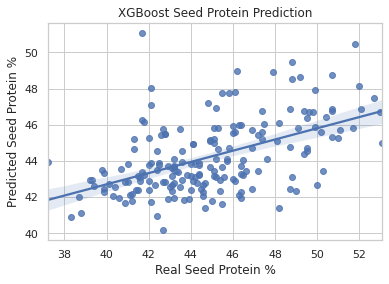

In [20]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()

for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Protein':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Protein", y="preds", data=thisplot)
plt.xlabel('Real Seed Protein %')
plt.ylabel('Predicted Seed Protein %')
plt.title("XGBoost Seed Protein Prediction")
plt.show()

In [21]:
pickle.dump(best_model, open("Protein_kfold_10_XGB_QTL.pickle.dat", "wb"))

In [22]:
#only load if not generated in same session
best_model = pickle.load(open("Protein_kfold_10_XGB_QTL.pickle.dat", "rb"))

<Figure size 1440x1440 with 0 Axes>

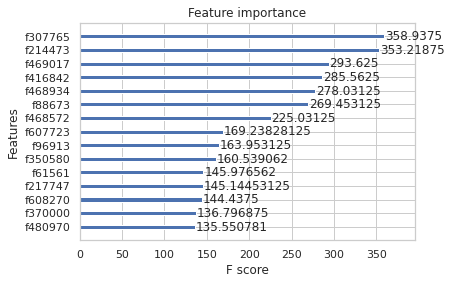

In [21]:
from xgboost import plot_importance
from matplotlib import pyplot
#best_model = pickle.load(open("Oil_kfold_10_tt_from_all.pickle.dat", "rb"))
plt.figure(figsize = (20, 20))
plot_importance(best_model, max_num_features=15, importance_type='gain', height=0.3)
pyplot.show()

In [23]:
#This function essentially returns an array of dataframe headers the length of OHE'd input SNPs for training data
#EG. It will be able to determine that feature 357310 is Gm13_17683957 but not what allele it is
#eg. feature 357309 357310 and 357311 may all be one hot encoded versions of all possible values of Gm13_17683957
#iterating through the saved OHE will by able to determine what specific allele the feature is but cannot determine
#what SNP header it belongs to. Therefore combining these two methods you can determine both allele and SNP
snp = []
imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
fs_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
x = 0
n_headers = []
le = LabelEncoder()
#while (i < 10):
for chunk in pd.read_csv("Pro_Merged_filtered.csv_train_testQTL_SNPS.csv", chunksize=10000, index_col="Unnamed: 0"):
    chunk = chunk.T
    if 'Value' in chunk.columns:
        print("dropping value so it doesn't include that in headers")
        chunk = chunk.drop(columns=['Value'])
    headers = chunk.columns
    row_idx = chunk.index
    chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
    #since imputing makes a numpy array have to turn back into PD for label encoding
    chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
    chunk = chunk.apply(lambda col: le.fit_transform(col))
    c_headers = chunk.columns
    y = 0
    for column in chunk:
        d = (chunk[column].nunique())
        n_headers.extend([c_headers[y] for i in range(d)])
        #print(n_headers)
        #print(l)
        #n_headers.append(c_headers[y] * d)
        #print(n_headers)
        y = y + 1
    #to double check that it would indeed be one hot encoded with this amount of columns
    chunk = fs_ohe.fit_transform(chunk)
    x = x + chunk.shape[1]
    print("my X value is: " + str(x))
    print(chunk.shape)
    print("my header list is: " + str(len(n_headers)))
print(len(n_headers))

my X value is: 29440
(753, 29440)
my header list is: 29440
my X value is: 59037
(753, 29597)
my header list is: 59037
dropping value so it doesn't include that in headers
my X value is: 67713
(753, 8676)
my header list is: 67713
67713


Gm11_11627036 (A/A)
Gm08_8878746 (A/A)
Gm16_32914642 (T/T)
Gm15_17702290 (C/C)
Gm16_32860230 (C/C)
Gm03_37416384 (G/G)
Gm16_32492446 (A/A)
Gm20_32826313 (T/T)
Gm04_4274844 (A/A)
Gm13_10976897 (T/T)
Gm03_673949 (A/A)
Gm08_13948647 (A/A)
Gm20_33580709 (G/G)
Gm13_40101648 (G/G)
Gm17_12128110 (A/A)
15
15


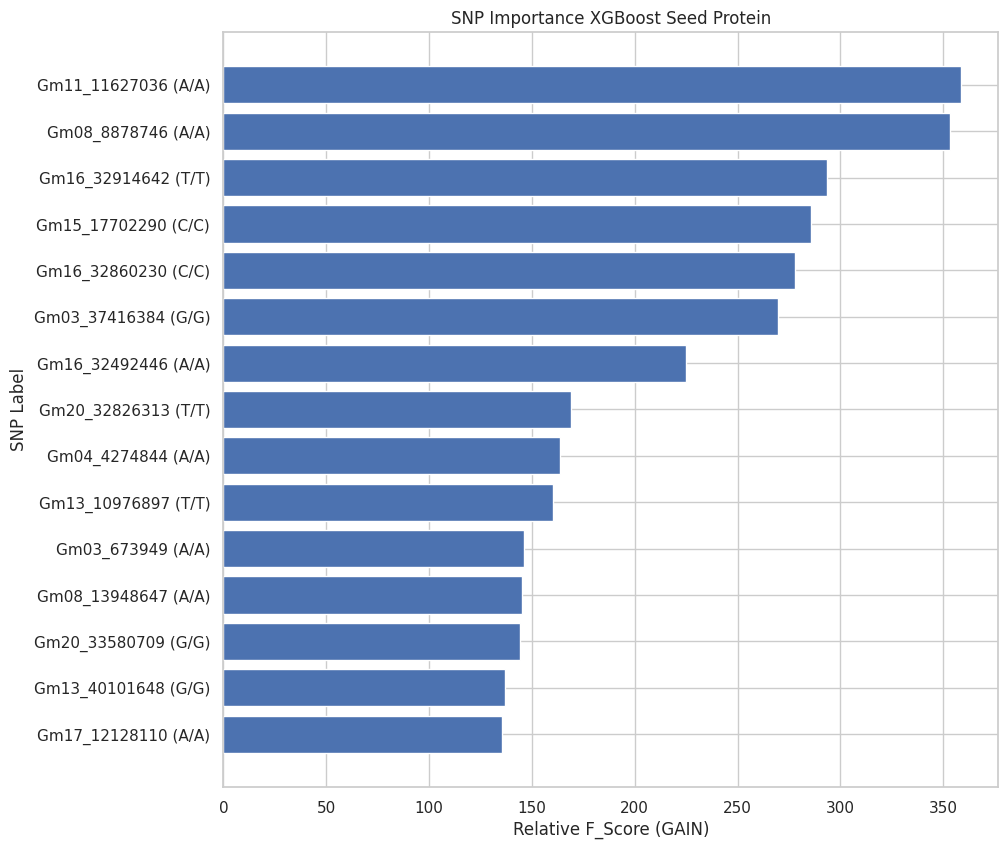

In [26]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
snp_label = []
fs = [307765,214473,469017,416842,468934,88673,468572,607723,96913,350580,61561,217747,608270,370000,480970]
scores = [358.9,353.2,293.6,285.56,278,269.5,225,169.2,163.9,160.5,146,145.1,144.4,136.8,135.6]
for jj in fs:
    jj_allele = find_snp_from_header(ohe, jj)
    this_snp = (n_headers[jj] + ' ('+str(jj_allele)+')')
    print(this_snp)
    snp_label.append(this_snp)
snp_label.reverse()
scores.reverse()
print(len(scores))
print(len(snp_label))
plt.barh(snp_label,scores)
plt.title('SNP Importance XGBoost Seed Protein')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

In [24]:
my_dict = best_model.get_booster().get_score(importance_type="gain")

In [25]:
def rename_f_header(fn,n_headers,ohe):
    fn = fn[1:]
    fn = int(fn)
    allele = find_snp_from_header(ohe, fn)
    this_snp = (n_headers[fn] + ' ('+str(allele)+')')
    return this_snp

In [26]:
#convert feature to actual SNP name
i = 0
new_dict = {}
for key in my_dict:
    new_key = rename_f_header(key, n_headers, ohe)
    new_dict[new_key] = my_dict[key]
    i = i + 1
    print(str(i))
    if(my_dict):
        continue
    else:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083


3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743


5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402


6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044


8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685


10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
1032

11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
1173

12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
1313

14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
1452

In [27]:
new_fi = pd.Series(new_dict)
print(new_fi)
df = new_fi.to_frame()
df = df.rename(columns = {0:'F_Score(GAIN)'})

Gm08_8505977 (T/C)     0.028458
Gm08_8544943 (T/T)     0.316847
Gm08_8629782 (T/T)     0.340454
Gm08_8502498 (C/C)     0.167030
Gm08_8984623 (A/A)     0.017213
                         ...   
Gm08_9497855 (A/A)     0.000225
Gm16_32977457 (C/C)    0.000015
Gm08_9073881 (C/C)     0.003224
Gm08_8899475 (T/T)     0.000051
Gm08_8615231 (T/G)     0.000194
Length: 15475, dtype: float64


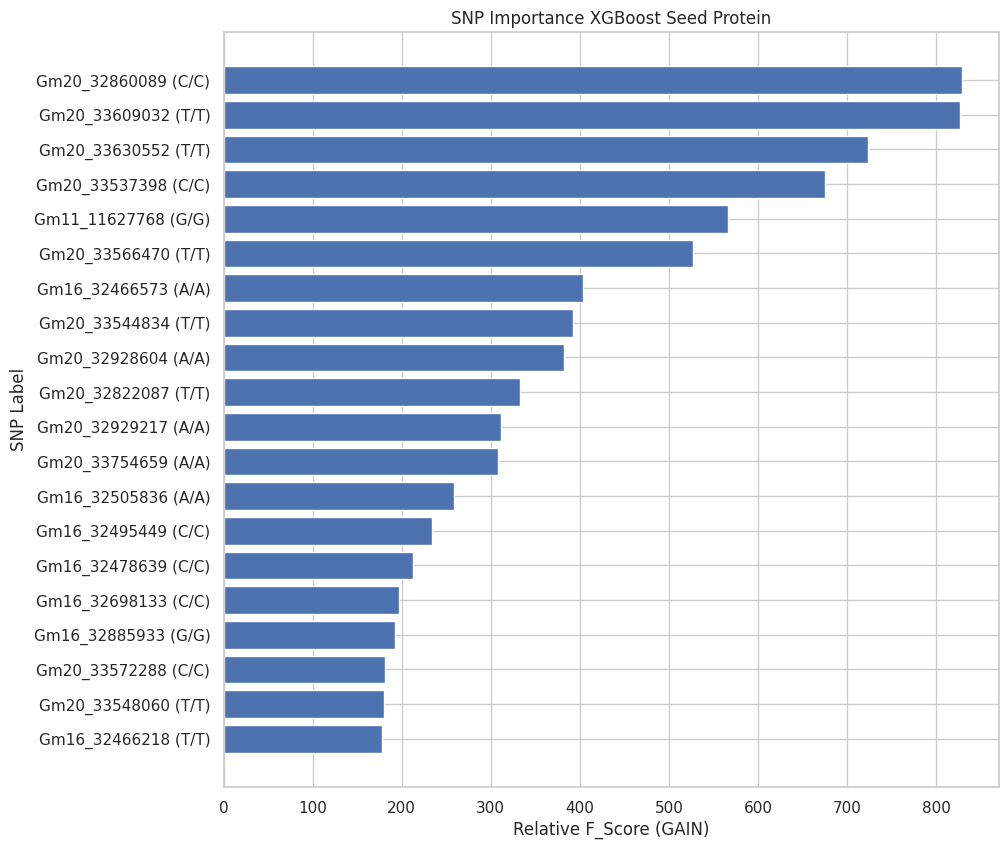

In [28]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
plt.barh(indexes, values)
plt.title('SNP Importance XGBoost Seed Protein')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

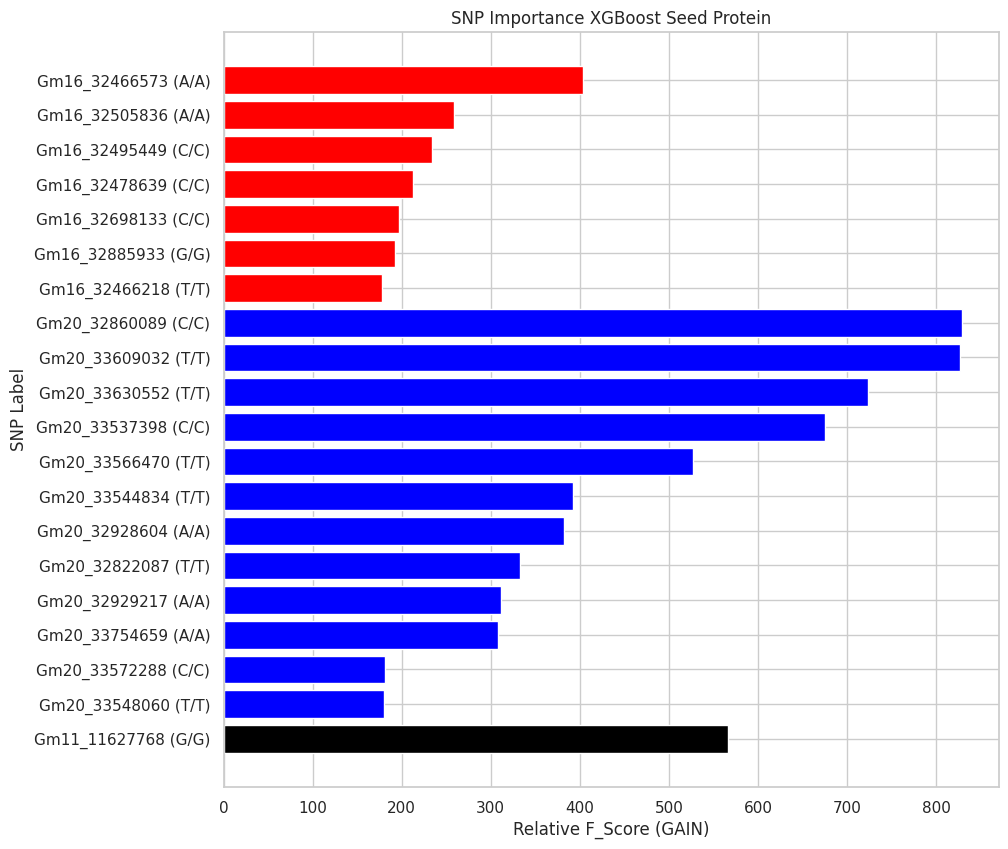

In [29]:
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
r_i = []
r_v = []
b_i = []
b_v = []
g_i = []
g_v = []
y_i = []
y_v = []
bl_i = []
bl_v = []
p_i = []
p_v = []
br_i = []
br_v = []
pu_i = []
pu_v = []
i = 0
while i < len(indexes):
    if('Gm16' in indexes[i]):
        r_i.append(indexes[i])
        r_v.append(values[i])
    elif('Gm20' in indexes[i]):
        b_i.append(indexes[i])
        b_v.append(values[i])
    elif('Gm15' in indexes[i]):
        g_i.append(indexes[i])
        g_v.append(values[i])
    elif('Gm03' in indexes[i]):
        y_i.append(indexes[i])
        y_v.append(values[i])
    elif('Gm08' in indexes[i]):
        p_i.append(indexes[i])
        p_v.append(values[i])
    elif('Gm04' in indexes[i]):
        br_i.append(indexes[i])
        br_v.append(values[i])
    elif('Gm13' in indexes[i]):
        pu_i.append(indexes[i])
        pu_v.append(values[i])
    else:
        bl_i.append(indexes[i])
        bl_v.append(values[i])
    i = i + 1
plt.barh(bl_i, bl_v, color="black")
plt.barh(br_i, br_v, color="brown")
plt.barh(pu_i, pu_v, color="purple")
plt.barh(g_i, g_v, color="green")
plt.barh(y_i, y_v, color="yellow")
plt.barh(p_i, p_v, color="orange")
plt.barh(b_i, b_v, color="blue")
plt.barh(r_i, r_v, color="red")
plt.title('SNP Importance XGBoost Seed Protein')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

# Random Forest Model

In [30]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("Pro_Merged_filtered.csv_train_testQTL_SNPS.csv", "Pro_Merged_filtered.csv_holdoutQTL_SNPS.csv")

10000
20000
(753,)
(753, 1)
30000
10000
20000
(189,)
(189, 1)
30000
(753, 23023)
(189, 23023)


In [31]:
ohe = pickle.load(open("Pro_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(753, 67713)
(189, 23023)
(189, 67713)


In [32]:
model = RandomForestRegressor(n_estimators=100, random_state=16, max_features = 'sqrt',n_jobs=-1, verbose = 1)
#trains the model, and makes the y shape as (m,) instead of (m,1)
#model.fit(X_train, y_train.ravel())

In [ ]:
best_rf_model = eval_k_fold(model, tt_vcf, tt_pheno, 10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: -1.7487773014896009
RMSE for dataset is:2.8986214450679473& mean of this fold is 44.627632
this is 6.495127135364162% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.


In [ ]:
all_preds = [x for x in best_rf_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

In [ ]:
pickle.dump(best_rf_model, open("Protein_kfold_10_RF_QTL.pickle.dat", "wb"))

In [ ]:
#only load if not generated in same session
best_rf_model = pickle.load(open("Protein_kfold_10_RF_QTL.pickle.dat", "rb"))

# CNN Model (Based upon DL Primer & GMStools)

In [10]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('Pro_Merged_filtered.csv_train_testQTL_SNPS.csv', 'Pro_Merged_filtered.csv_holdoutQTL_SNPS.csv')

10000
20000
(753,)
(753, 1)
30000
10000
20000
(189,)
(189, 1)
30000
(753, 23023)
(189, 23023)


In [11]:
ohe = pickle.load(open("Pro_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(753, 67713)
(189, 23023)
(189, 67713)


In [12]:
def build_CNN_model(train_size):    
    #del model
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=14, 
                     input_shape=(train_size, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=10, kernel_size=10, 
                     input_shape=(12, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=8, kernel_size=8, 
                     input_shape=(10, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(48, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"


    model.compile(loss='mean_squared_error', optimizer=opt, 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    print(model.summary())
    return model

In [15]:
def eval_CNN(x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = []
    i = 1
    for train,test in cv.split(x,y):
        m = build_CNN_model(x.shape[1])
        print("Fold:" + str(i))
        x = x.reshape(x.shape[0], x.shape[1], 1)
        bs = ((x[train].shape[0])/50)
        bs = round(bs)
        m.fit(x[train],y[train].ravel(), validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
        del m
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [16]:
#my_model = build_CNN_model()
best_model = eval_CNN(tt_vcf, tt_pheno, 10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 67700, 12)         180       
_________________________________________________________________
activation_3 (Activation)    (None, 67700, 12)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 67700, 12)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 67691, 10)         1210      
_________________________________________________________________
activation_4 (Activation)    (None, 67691, 10)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 67691, 10)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 67684, 8)         

Epoch 33/100
677/677 [==============================] - 1s 1ms/sample - loss: 2.3326 - root_mean_squared_error: 1.5273 - val_loss: 11.2782 - val_root_mean_squared_error: 3.3583
Epoch 34/100
677/677 [==============================] - 1s 1ms/sample - loss: 2.0292 - root_mean_squared_error: 1.4245 - val_loss: 10.7892 - val_root_mean_squared_error: 3.2847
Epoch 35/100
677/677 [==============================] - 1s 1ms/sample - loss: 2.3643 - root_mean_squared_error: 1.5376 - val_loss: 6.0743 - val_root_mean_squared_error: 2.4646
Epoch 36/100
677/677 [==============================] - 1s 1ms/sample - loss: 1.8700 - root_mean_squared_error: 1.3675 - val_loss: 9.8318 - val_root_mean_squared_error: 3.1356
Epoch 37/100
677/677 [==============================] - 1s 1ms/sample - loss: 1.9799 - root_mean_squared_error: 1.4071 - val_loss: 8.3076 - val_root_mean_squared_error: 2.8823
Epoch 38/100
677/677 [==============================] - 1s 1ms/sample - loss: 1.9718 - root_mean_squared_error: 1.4042

Epoch 10/100
677/677 [==============================] - 1s 1ms/sample - loss: 162.0067 - root_mean_squared_error: 12.7282 - val_loss: 45.9252 - val_root_mean_squared_error: 6.7768
Epoch 11/100
677/677 [==============================] - 1s 1ms/sample - loss: 74.1022 - root_mean_squared_error: 8.6083 - val_loss: 16.8716 - val_root_mean_squared_error: 4.1075
Epoch 12/100
677/677 [==============================] - 1s 1ms/sample - loss: 30.7542 - root_mean_squared_error: 5.5457 - val_loss: 16.1544 - val_root_mean_squared_error: 4.0193
Epoch 13/100
677/677 [==============================] - 1s 1ms/sample - loss: 12.1812 - root_mean_squared_error: 3.4902 - val_loss: 11.4609 - val_root_mean_squared_error: 3.3854
Epoch 14/100
677/677 [==============================] - 1s 1ms/sample - loss: 5.7045 - root_mean_squared_error: 2.3884 - val_loss: 14.2222 - val_root_mean_squared_error: 3.7712
Epoch 15/100
677/677 [==============================] - 1s 1ms/sample - loss: 3.7559 - root_mean_squared_erro

Train on 677 samples, validate on 76 samples
Epoch 1/100
677/677 [==============================] - 2s 3ms/sample - loss: 1946.6256 - root_mean_squared_error: 44.1206 - val_loss: 1613.2112 - val_root_mean_squared_error: 40.1648
Epoch 2/100
677/677 [==============================] - 1s 1ms/sample - loss: 1838.3583 - root_mean_squared_error: 42.8761 - val_loss: 1349.1298 - val_root_mean_squared_error: 36.7305
Epoch 3/100
677/677 [==============================] - 1s 1ms/sample - loss: 1686.4441 - root_mean_squared_error: 41.0663 - val_loss: 1110.5199 - val_root_mean_squared_error: 33.3245
Epoch 4/100
677/677 [==============================] - 1s 1ms/sample - loss: 1494.1895 - root_mean_squared_error: 38.6547 - val_loss: 888.2161 - val_root_mean_squared_error: 29.8030
Epoch 5/100
677/677 [==============================] - 1s 1ms/sample - loss: 1265.9047 - root_mean_squared_error: 35.5796 - val_loss: 685.6472 - val_root_mean_squared_error: 26.1849
Epoch 6/100
677/677 [=====================

Epoch 47/100
677/677 [==============================] - 1s 1ms/sample - loss: 1.3318 - root_mean_squared_error: 1.1540 - val_loss: 9.3758 - val_root_mean_squared_error: 3.0620
Epoch 48/100
677/677 [==============================] - 1s 1ms/sample - loss: 2.2693 - root_mean_squared_error: 1.5064 - val_loss: 11.6550 - val_root_mean_squared_error: 3.4139
Epoch 49/100
677/677 [==============================] - 1s 2ms/sample - loss: 2.3119 - root_mean_squared_error: 1.5205 - val_loss: 13.1131 - val_root_mean_squared_error: 3.6212
Epoch 50/100
677/677 [==============================] - 1s 1ms/sample - loss: 1.6646 - root_mean_squared_error: 1.2902 - val_loss: 9.7404 - val_root_mean_squared_error: 3.1210
Epoch 51/100
677/677 [==============================] - 1s 1ms/sample - loss: 2.0522 - root_mean_squared_error: 1.4325 - val_loss: 8.9139 - val_root_mean_squared_error: 2.9856
Epoch 52/100
677/677 [==============================] - 1s 1ms/sample - loss: 1.9664 - root_mean_squared_error: 1.4023

678/678 [==============================] - 1s 1ms/sample - loss: 2.0205 - root_mean_squared_error: 1.4214 - val_loss: 6.1781 - val_root_mean_squared_error: 2.4856
Epoch 24/100
678/678 [==============================] - 1s 1ms/sample - loss: 2.1032 - root_mean_squared_error: 1.4502 - val_loss: 7.7950 - val_root_mean_squared_error: 2.7920
Epoch 25/100
678/678 [==============================] - 1s 2ms/sample - loss: 1.8578 - root_mean_squared_error: 1.3630 - val_loss: 14.4357 - val_root_mean_squared_error: 3.7994
Epoch 26/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.8988 - root_mean_squared_error: 1.3780 - val_loss: 7.2631 - val_root_mean_squared_error: 2.6950
Epoch 27/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.9532 - root_mean_squared_error: 1.3976 - val_loss: 6.8604 - val_root_mean_squared_error: 2.6192
Epoch 28/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.8403 - root_mean_squared_error: 1.3566 - val_loss: 9

Train on 678 samples, validate on 75 samples
Epoch 1/100
678/678 [==============================] - 2s 3ms/sample - loss: 1942.0047 - root_mean_squared_error: 44.0682 - val_loss: 1801.0380 - val_root_mean_squared_error: 42.4386
Epoch 2/100
678/678 [==============================] - 1s 1ms/sample - loss: 1845.5693 - root_mean_squared_error: 42.9601 - val_loss: 1464.7592 - val_root_mean_squared_error: 38.2722
Epoch 3/100
678/678 [==============================] - 1s 1ms/sample - loss: 1703.6872 - root_mean_squared_error: 41.2757 - val_loss: 1191.5030 - val_root_mean_squared_error: 34.5182
Epoch 4/100
678/678 [==============================] - 1s 1ms/sample - loss: 1518.0344 - root_mean_squared_error: 38.9620 - val_loss: 941.7889 - val_root_mean_squared_error: 30.6886
Epoch 5/100
678/678 [==============================] - 1s 1ms/sample - loss: 1297.8191 - root_mean_squared_error: 36.0253 - val_loss: 759.3964 - val_root_mean_squared_error: 27.5571
Epoch 6/100
678/678 [=====================

Epoch 47/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.1291 - root_mean_squared_error: 1.0626 - val_loss: 9.6098 - val_root_mean_squared_error: 3.1000
Epoch 48/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.6756 - root_mean_squared_error: 1.2944 - val_loss: 18.8653 - val_root_mean_squared_error: 4.3434
Epoch 49/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.3392 - root_mean_squared_error: 1.1572 - val_loss: 8.0251 - val_root_mean_squared_error: 2.8329
Epoch 50/100
678/678 [==============================] - 1s 2ms/sample - loss: 1.3026 - root_mean_squared_error: 1.1413 - val_loss: 7.9643 - val_root_mean_squared_error: 2.8221
Epoch 51/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.9607 - root_mean_squared_error: 1.4002 - val_loss: 14.6247 - val_root_mean_squared_error: 3.8242
Epoch 52/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.9734 - root_mean_squared_error: 1.4048

678/678 [==============================] - 1s 1ms/sample - loss: 2.1683 - root_mean_squared_error: 1.4725 - val_loss: 9.0858 - val_root_mean_squared_error: 3.0143
Epoch 24/100
678/678 [==============================] - 1s 2ms/sample - loss: 2.0101 - root_mean_squared_error: 1.4178 - val_loss: 9.0813 - val_root_mean_squared_error: 3.0135
Epoch 25/100
678/678 [==============================] - 1s 1ms/sample - loss: 2.0520 - root_mean_squared_error: 1.4325 - val_loss: 9.3707 - val_root_mean_squared_error: 3.0612
Epoch 26/100
678/678 [==============================] - 1s 1ms/sample - loss: 2.1037 - root_mean_squared_error: 1.4504 - val_loss: 9.4720 - val_root_mean_squared_error: 3.0777
Epoch 27/100
678/678 [==============================] - 1s 2ms/sample - loss: 2.4347 - root_mean_squared_error: 1.5604 - val_loss: 9.7161 - val_root_mean_squared_error: 3.1171
Epoch 28/100
678/678 [==============================] - 1s 1ms/sample - loss: 2.4145 - root_mean_squared_error: 1.5539 - val_loss: 19

Train on 678 samples, validate on 75 samples
Epoch 1/100
678/678 [==============================] - 4s 6ms/sample - loss: 1944.7830 - root_mean_squared_error: 44.0997 - val_loss: 1835.4648 - val_root_mean_squared_error: 42.8423
Epoch 2/100
678/678 [==============================] - 1s 2ms/sample - loss: 1840.4043 - root_mean_squared_error: 42.8999 - val_loss: 1576.4047 - val_root_mean_squared_error: 39.7040
Epoch 3/100
678/678 [==============================] - 1s 1ms/sample - loss: 1692.5286 - root_mean_squared_error: 41.1404 - val_loss: 1361.8240 - val_root_mean_squared_error: 36.9029
Epoch 4/100
678/678 [==============================] - 1s 2ms/sample - loss: 1502.1169 - root_mean_squared_error: 38.7571 - val_loss: 1093.3336 - val_root_mean_squared_error: 33.0656
Epoch 5/100
678/678 [==============================] - 1s 1ms/sample - loss: 1276.6130 - root_mean_squared_error: 35.7297 - val_loss: 862.9737 - val_root_mean_squared_error: 29.3764
Epoch 6/100
678/678 [====================

Epoch 47/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.4714 - root_mean_squared_error: 1.2130 - val_loss: 9.4758 - val_root_mean_squared_error: 3.0783
Epoch 48/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.2264 - root_mean_squared_error: 1.1074 - val_loss: 9.3770 - val_root_mean_squared_error: 3.0622
Epoch 49/100
678/678 [==============================] - 2s 4ms/sample - loss: 1.3883 - root_mean_squared_error: 1.1783 - val_loss: 9.5376 - val_root_mean_squared_error: 3.0883
Epoch 50/100
678/678 [==============================] - 1s 1ms/sample - loss: 0.9906 - root_mean_squared_error: 0.9953 - val_loss: 10.2387 - val_root_mean_squared_error: 3.1998
Epoch 51/100
678/678 [==============================] - 1s 2ms/sample - loss: 1.3447 - root_mean_squared_error: 1.1596 - val_loss: 10.2569 - val_root_mean_squared_error: 3.2026
Epoch 52/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.3174 - root_mean_squared_error: 1.1478

678/678 [==============================] - 1s 1ms/sample - loss: 2.0620 - root_mean_squared_error: 1.4360 - val_loss: 10.3380 - val_root_mean_squared_error: 3.2153
Epoch 24/100
678/678 [==============================] - 1s 1ms/sample - loss: 2.2970 - root_mean_squared_error: 1.5156 - val_loss: 8.7050 - val_root_mean_squared_error: 2.9504
Epoch 25/100
678/678 [==============================] - 1s 1ms/sample - loss: 2.1889 - root_mean_squared_error: 1.4795 - val_loss: 10.3835 - val_root_mean_squared_error: 3.2223
Epoch 26/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.9980 - root_mean_squared_error: 1.4135 - val_loss: 10.1065 - val_root_mean_squared_error: 3.1791
Epoch 27/100
678/678 [==============================] - 1s 1ms/sample - loss: 2.3117 - root_mean_squared_error: 1.5204 - val_loss: 9.3084 - val_root_mean_squared_error: 3.0510
Epoch 28/100
678/678 [==============================] - 1s 1ms/sample - loss: 2.1381 - root_mean_squared_error: 1.4622 - val_loss:

Train on 678 samples, validate on 75 samples
Epoch 1/100
678/678 [==============================] - 2s 3ms/sample - loss: 1933.2049 - root_mean_squared_error: 43.9682 - val_loss: 1944.9712 - val_root_mean_squared_error: 44.1018
Epoch 2/100
678/678 [==============================] - 1s 1ms/sample - loss: 1813.5551 - root_mean_squared_error: 42.5859 - val_loss: 1818.3957 - val_root_mean_squared_error: 42.6427
Epoch 3/100
678/678 [==============================] - 1s 1ms/sample - loss: 1649.8497 - root_mean_squared_error: 40.6183 - val_loss: 1623.3228 - val_root_mean_squared_error: 40.2905
Epoch 4/100
678/678 [==============================] - 1s 1ms/sample - loss: 1446.5119 - root_mean_squared_error: 38.0330 - val_loss: 1489.1538 - val_root_mean_squared_error: 38.5896
Epoch 5/100
678/678 [==============================] - 1s 1ms/sample - loss: 1212.9831 - root_mean_squared_error: 34.8279 - val_loss: 1200.4924 - val_root_mean_squared_error: 34.6481
Epoch 6/100
678/678 [===================

Epoch 47/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.7117 - root_mean_squared_error: 1.3083 - val_loss: 11.5385 - val_root_mean_squared_error: 3.3968
Epoch 48/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.4863 - root_mean_squared_error: 1.2191 - val_loss: 8.7275 - val_root_mean_squared_error: 2.9542
Epoch 49/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.5779 - root_mean_squared_error: 1.2561 - val_loss: 8.1453 - val_root_mean_squared_error: 2.8540
Epoch 50/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.3043 - root_mean_squared_error: 1.1421 - val_loss: 8.1327 - val_root_mean_squared_error: 2.8518
Epoch 51/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.5141 - root_mean_squared_error: 1.2305 - val_loss: 8.7949 - val_root_mean_squared_error: 2.9656
Epoch 52/100
678/678 [==============================] - 1s 1ms/sample - loss: 1.5674 - root_mean_squared_error: 1.2519 

678/678 [==============================] - 1s 1ms/sample - loss: 2.6726 - root_mean_squared_error: 1.6348 - val_loss: 6.5511 - val_root_mean_squared_error: 2.5595
Epoch 24/100
678/678 [==============================] - 1s 1ms/sample - loss: 2.4047 - root_mean_squared_error: 1.5507 - val_loss: 6.5200 - val_root_mean_squared_error: 2.5534
Epoch 25/100
678/678 [==============================] - 1s 1ms/sample - loss: 3.4435 - root_mean_squared_error: 1.8557 - val_loss: 11.4305 - val_root_mean_squared_error: 3.3809
Epoch 26/100
678/678 [==============================] - 1s 1ms/sample - loss: 3.4575 - root_mean_squared_error: 1.8594 - val_loss: 18.8242 - val_root_mean_squared_error: 4.3387
Epoch 27/100
678/678 [==============================] - 1s 1ms/sample - loss: 2.8177 - root_mean_squared_error: 1.6786 - val_loss: 36.0350 - val_root_mean_squared_error: 6.0029
Epoch 28/100
678/678 [==============================] - 1s 1ms/sample - loss: 2.1291 - root_mean_squared_error: 1.4591 - val_loss:

In [ ]:
pickle.dump(best_model, open("Pro_kfold_10_CNN_QTL.pickle.dat", "wb"))

In [ ]:
best_CNN = pickle.load(open("Pro_kfold_10_CNN_QTL.pickle.dat", "rb"))

In [17]:
ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1], 1)
all_preds = [x for x in best_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: -0.82
RMSE of Holdout: 3.02
Mean of Holdout: 44.92
this is 6.725383319011001% of the mean pheno data


False
False
0 44.0 [45.317493]
1 40.4 [43.10047]
2 50.7 [48.3221]
3 38.8 [43.725483]
4 45.5 [42.195843]
5 43.1 [43.974754]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

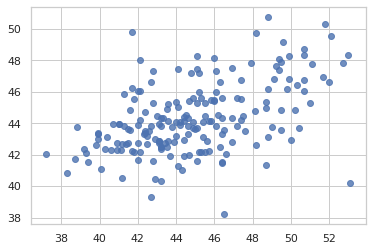

In [18]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()
print(np.isinf(ho_pheno).any())
print(np.isinf(all_preds).any())
for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Pro':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Pro", y="preds", data=thisplot)
plt.xlabel('Real Seed Protein %')
plt.ylabel('Predicted Seed Protein %')
plt.title("XGBoost Seed Protein Prediction")
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=100, facecolor='w', edgecolor='k')
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="Actual %")
plt.plot(x_ax, all_preds, label="Predicted %") 

plt.title("Seed Oil % Predicted vs Actual")
plt.xlabel('Validation Sample')
plt.ylabel('Seed Oil Percentage')

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
all_preds = [x[0] for x in model.predict(X_test)]
sqrt(mean_squared_error(all_preds, y_test))
r2_score(all_preds, y_test)
vcf = vcf.reshape(vcf.shape[0], vcf.shape[1], 1)
d = {'targs': [x for x in pheno], 'preds': [x[0] for x in model.predict(vcf)]}

testdf = pd.DataFrame(data=d)
testdf['minus'] = testdf['targs'] - testdf['preds']

ss = sqrt(mean_squared_error(testdf["preds"], testdf['targs']))
mm = np.mean(pheno)
print("RMSE for dataset is:" +str(ss) + "& pheno is " + str(mm))
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

# DNN model
#### Model Based upon: Crop Yield Prediction Using Deep Neural Networks(2019)

In [19]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('Pro_Merged_filtered.csv_train_testQTL_SNPS.csv', 'Pro_Merged_filtered.csv_holdoutQTL_SNPS.csv')

10000
20000
(753,)
(753, 1)
30000
10000
20000
(189,)
(189, 1)
30000
(753, 23023)
(189, 23023)


In [20]:
ohe = pickle.load(open("Pro_QTL_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(753, 67713)
(189, 23023)
(189, 67713)


In [21]:
#My own DNN model based upon paper
#del model #incase its stored a previous model
#del history #for redoing shit

#do batch size as 64
#reduce the inputs by half when you read it in
#add XGboost and RF to the one notebook
def build_DNN_model(x_len):
    model = Sequential()

    #add first input layer, with no normalization
    model.add(Dense(200, input_dim = x_len))
    model.add(Activation('relu'))
    model.add(Dropout(0.03))
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.02))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.01))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    #add output layer
    model.add(Dense(1, activation='linear'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    print(model.summary())
    return model




In [22]:
def eval_DNN(x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = []
    i = 1
    for train,test in cv.split(x,y):
        m = build_DNN_model(x.shape[1])
        print("Fold:" + str(i))
        bs = ((x[train].shape[0])/50)
        bs = round(bs)
        m.fit(x[train],y[train].ravel(), validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
        del m
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [ ]:
#my_model = build_CNN_model()
best_DNN = eval_DNN(tt_vcf, tt_pheno, 10)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 200)               13542800  
_________________________________________________________________
activation_33 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_34 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 64)              

677/677 [==============================] - 0s 587us/sample - loss: 3.5845 - root_mean_squared_error: 1.8933 - val_loss: 5.5637 - val_root_mean_squared_error: 2.3588
Epoch 80/100
677/677 [==============================] - 0s 590us/sample - loss: 3.1760 - root_mean_squared_error: 1.7821 - val_loss: 5.7876 - val_root_mean_squared_error: 2.4057
Epoch 81/100
677/677 [==============================] - 0s 589us/sample - loss: 2.7497 - root_mean_squared_error: 1.6582 - val_loss: 6.9332 - val_root_mean_squared_error: 2.6331
Epoch 82/100
677/677 [==============================] - 0s 591us/sample - loss: 3.0028 - root_mean_squared_error: 1.7329 - val_loss: 5.6619 - val_root_mean_squared_error: 2.3795
Epoch 83/100
677/677 [==============================] - 0s 592us/sample - loss: 2.9663 - root_mean_squared_error: 1.7223 - val_loss: 6.0951 - val_root_mean_squared_error: 2.4688
Epoch 84/100
677/677 [==============================] - 0s 589us/sample - loss: 2.7937 - root_mean_squared_error: 1.6714 - 

Epoch 56/100
677/677 [==============================] - 0s 587us/sample - loss: 8.8066 - root_mean_squared_error: 2.9676 - val_loss: 6.8151 - val_root_mean_squared_error: 2.6106
Epoch 57/100
677/677 [==============================] - 0s 587us/sample - loss: 12.1563 - root_mean_squared_error: 3.4866 - val_loss: 15.5449 - val_root_mean_squared_error: 3.9427
Epoch 58/100
677/677 [==============================] - 0s 586us/sample - loss: 10.3046 - root_mean_squared_error: 3.2101 - val_loss: 7.9333 - val_root_mean_squared_error: 2.8166
Epoch 59/100
677/677 [==============================] - 0s 587us/sample - loss: 8.3828 - root_mean_squared_error: 2.8953 - val_loss: 6.2368 - val_root_mean_squared_error: 2.4973
Epoch 60/100
677/677 [==============================] - 0s 586us/sample - loss: 8.9600 - root_mean_squared_error: 2.9933 - val_loss: 5.5990 - val_root_mean_squared_error: 2.3662
Epoch 61/100
677/677 [==============================] - 0s 585us/sample - loss: 7.2711 - root_mean_squared_

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 200)               13542800  
_________________________________________________________________
activation_43 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_44 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 64)              

677/677 [==============================] - 0s 584us/sample - loss: 4.4065 - root_mean_squared_error: 2.0992 - val_loss: 8.1816 - val_root_mean_squared_error: 2.8603
Epoch 80/100
677/677 [==============================] - 0s 583us/sample - loss: 4.2435 - root_mean_squared_error: 2.0600 - val_loss: 7.4524 - val_root_mean_squared_error: 2.7299
Epoch 81/100
677/677 [==============================] - 0s 585us/sample - loss: 4.1315 - root_mean_squared_error: 2.0326 - val_loss: 7.8469 - val_root_mean_squared_error: 2.8012
Epoch 82/100
677/677 [==============================] - 0s 586us/sample - loss: 4.2852 - root_mean_squared_error: 2.0701 - val_loss: 8.5516 - val_root_mean_squared_error: 2.9243
Epoch 83/100
677/677 [==============================] - 0s 585us/sample - loss: 4.5466 - root_mean_squared_error: 2.1323 - val_loss: 7.9247 - val_root_mean_squared_error: 2.8151
Epoch 84/100
677/677 [==============================] - 0s 583us/sample - loss: 4.2742 - root_mean_squared_error: 2.0674 - 

Epoch 56/100
678/678 [==============================] - 0s 584us/sample - loss: 7.1214 - root_mean_squared_error: 2.6686 - val_loss: 6.6180 - val_root_mean_squared_error: 2.5725
Epoch 57/100
678/678 [==============================] - 0s 585us/sample - loss: 8.3647 - root_mean_squared_error: 2.8922 - val_loss: 6.7236 - val_root_mean_squared_error: 2.5930
Epoch 58/100
678/678 [==============================] - 0s 581us/sample - loss: 7.3712 - root_mean_squared_error: 2.7150 - val_loss: 7.3359 - val_root_mean_squared_error: 2.7085
Epoch 59/100
678/678 [==============================] - 0s 584us/sample - loss: 5.5611 - root_mean_squared_error: 2.3582 - val_loss: 6.7238 - val_root_mean_squared_error: 2.5930
Epoch 60/100
678/678 [==============================] - 0s 583us/sample - loss: 6.7414 - root_mean_squared_error: 2.5964 - val_loss: 7.3250 - val_root_mean_squared_error: 2.7065
Epoch 61/100
678/678 [==============================] - 0s 582us/sample - loss: 6.1458 - root_mean_squared_err

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 200)               13542800  
_________________________________________________________________
activation_53 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_54 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 64)              

678/678 [==============================] - 0s 583us/sample - loss: 3.2920 - root_mean_squared_error: 1.8144 - val_loss: 13.6417 - val_root_mean_squared_error: 3.6935
Epoch 80/100
678/678 [==============================] - 0s 584us/sample - loss: 3.9601 - root_mean_squared_error: 1.9900 - val_loss: 8.0293 - val_root_mean_squared_error: 2.8336
Epoch 81/100
678/678 [==============================] - 0s 583us/sample - loss: 3.1132 - root_mean_squared_error: 1.7644 - val_loss: 7.7290 - val_root_mean_squared_error: 2.7801
Epoch 82/100
678/678 [==============================] - 0s 583us/sample - loss: 2.7964 - root_mean_squared_error: 1.6722 - val_loss: 10.4023 - val_root_mean_squared_error: 3.2253
Epoch 83/100
678/678 [==============================] - 0s 584us/sample - loss: 2.9566 - root_mean_squared_error: 1.7195 - val_loss: 6.8936 - val_root_mean_squared_error: 2.6256
Epoch 84/100
678/678 [==============================] - 0s 582us/sample - loss: 3.2974 - root_mean_squared_error: 1.8159 

Epoch 56/100
678/678 [==============================] - 0s 582us/sample - loss: 6.8191 - root_mean_squared_error: 2.6113 - val_loss: 7.5483 - val_root_mean_squared_error: 2.7474
Epoch 57/100
678/678 [==============================] - 0s 585us/sample - loss: 7.1274 - root_mean_squared_error: 2.6697 - val_loss: 7.9364 - val_root_mean_squared_error: 2.8172
Epoch 58/100
678/678 [==============================] - 0s 584us/sample - loss: 7.0919 - root_mean_squared_error: 2.6631 - val_loss: 8.9711 - val_root_mean_squared_error: 2.9952
Epoch 59/100
678/678 [==============================] - 0s 584us/sample - loss: 6.7726 - root_mean_squared_error: 2.6024 - val_loss: 7.7546 - val_root_mean_squared_error: 2.7847
Epoch 60/100
678/678 [==============================] - 0s 582us/sample - loss: 6.9314 - root_mean_squared_error: 2.6328 - val_loss: 7.8000 - val_root_mean_squared_error: 2.7928
Epoch 61/100
678/678 [==============================] - 0s 582us/sample - loss: 6.5191 - root_mean_squared_err

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 200)               13542800  
_________________________________________________________________
activation_63 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_64 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 64)              

678/678 [==============================] - 0s 580us/sample - loss: 2.9541 - root_mean_squared_error: 1.7188 - val_loss: 7.5764 - val_root_mean_squared_error: 2.7525
Epoch 80/100
678/678 [==============================] - 0s 582us/sample - loss: 2.5516 - root_mean_squared_error: 1.5974 - val_loss: 7.9716 - val_root_mean_squared_error: 2.8234
Epoch 81/100
678/678 [==============================] - 0s 580us/sample - loss: 4.1473 - root_mean_squared_error: 2.0365 - val_loss: 11.1177 - val_root_mean_squared_error: 3.3343
Epoch 82/100
678/678 [==============================] - 0s 580us/sample - loss: 4.1326 - root_mean_squared_error: 2.0329 - val_loss: 7.9330 - val_root_mean_squared_error: 2.8166
Epoch 83/100
678/678 [==============================] - 0s 581us/sample - loss: 3.0430 - root_mean_squared_error: 1.7444 - val_loss: 7.3257 - val_root_mean_squared_error: 2.7066
Epoch 84/100
678/678 [==============================] - 0s 580us/sample - loss: 2.5778 - root_mean_squared_error: 1.6055 -

Epoch 56/100
678/678 [==============================] - 0s 589us/sample - loss: 5.7303 - root_mean_squared_error: 2.3938 - val_loss: 10.6395 - val_root_mean_squared_error: 3.2618
Epoch 57/100
678/678 [==============================] - 0s 581us/sample - loss: 5.3168 - root_mean_squared_error: 2.3058 - val_loss: 10.9172 - val_root_mean_squared_error: 3.3041
Epoch 58/100
678/678 [==============================] - 0s 583us/sample - loss: 4.7193 - root_mean_squared_error: 2.1724 - val_loss: 9.5716 - val_root_mean_squared_error: 3.0938
Epoch 59/100
678/678 [==============================] - 0s 582us/sample - loss: 5.2342 - root_mean_squared_error: 2.2878 - val_loss: 10.9901 - val_root_mean_squared_error: 3.3151
Epoch 60/100
678/678 [==============================] - 0s 582us/sample - loss: 4.5943 - root_mean_squared_error: 2.1434 - val_loss: 9.8955 - val_root_mean_squared_error: 3.1457
Epoch 61/100
678/678 [==============================] - 0s 583us/sample - loss: 5.1075 - root_mean_squared_

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 200)               13542800  
_________________________________________________________________
activation_73 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_74 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 64)              

678/678 [==============================] - 0s 582us/sample - loss: 3.7176 - root_mean_squared_error: 1.9281 - val_loss: 9.4857 - val_root_mean_squared_error: 3.0799
Epoch 80/100
678/678 [==============================] - 0s 582us/sample - loss: 3.5691 - root_mean_squared_error: 1.8892 - val_loss: 8.0999 - val_root_mean_squared_error: 2.8460
Epoch 81/100
678/678 [==============================] - 0s 582us/sample - loss: 3.3970 - root_mean_squared_error: 1.8431 - val_loss: 7.3595 - val_root_mean_squared_error: 2.7128
Epoch 82/100
678/678 [==============================] - 0s 581us/sample - loss: 3.3875 - root_mean_squared_error: 1.8405 - val_loss: 8.3283 - val_root_mean_squared_error: 2.8859
Epoch 83/100
678/678 [==============================] - 0s 582us/sample - loss: 3.9417 - root_mean_squared_error: 1.9854 - val_loss: 9.2619 - val_root_mean_squared_error: 3.0433
Epoch 84/100
678/678 [==============================] - 0s 582us/sample - loss: 3.3959 - root_mean_squared_error: 1.8428 - 

In [ ]:
#ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1], 1)
all_preds = [x for x in best_DNN.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

0 17.6 [16.134573]
1 23.6 [19.051014]
2 15.1 [15.280489]
3 19.2 [18.973824]
4 14.5 [16.545984]
5 14.9 [14.623625]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

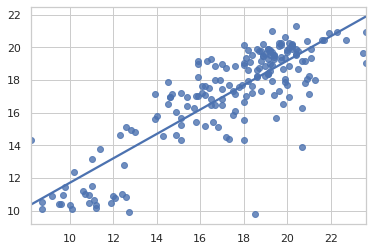

In [11]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()

for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Oil':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Oil", y="preds", data=thisplot)
plt.xlabel('Real Seed Oil %')
plt.ylabel('Predicted Seed Oil %')
plt.title("DNN Seed Oil Prediction")
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=100, facecolor='w', edgecolor='k')
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="Actual %")
plt.plot(x_ax, all_preds, label="Predicted %") 

plt.title("Seed Oil % Predicted vs Actual")
plt.xlabel('Validation Sample')
plt.ylabel('Seed Oil Percentage')

plt.legend()
plt.show()

In [ ]:
pickle.dump(best_DNN, open("Oil_kfold_10_DNN.pickle.dat", "wb"))

In [ ]:
best_DNN = pickle.load(open("Oil_kfold_10_DNN.pickle.dat", "rb"))

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

range(0, 189)


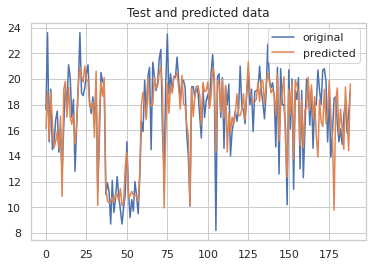

TypeError: list indices must be integers or slices, not range

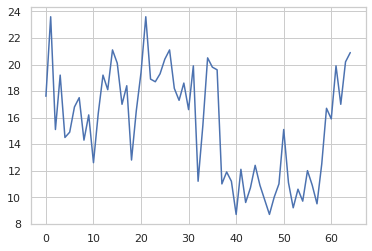

In [10]:
y_test=ho_pheno
x_ax = range(len(y_test))
print(x_ax)
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, all_preds, label="predicted") 

plt.title("Test and predicted data")

plt.legend()
plt.show()

i = 0
interval = 65
while(i<len(y_test)):
    i = i + interval
    if(i>len(y_test)):
        my_range = range(i-interval,len(y_test))
    else:
        my_range = range(i-interval,i)
    plt.plot(my_range, y_test[my_range], label="original")
    plt.plot(my_range, all_preds[my_range], label="predicted") 

    plt.title("Test and predicted data")

    plt.legend()
    plt.show()

In [ ]:
d = {'targs': [x for x in pheno], 'preds': [x[0] for x in model.predict(vcf)]}

testdf = pd.DataFrame(data=d)
testdf['minus'] = testdf['targs'] - testdf['preds']

In [ ]:
ss = sqrt(mean_squared_error(testdf["preds"], testdf['targs']))
mm = np.mean(pheno)
print("RMSE for dataset is:" +str(ss) + "& pheno is " + str(mm))
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")